In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from utils import *

import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

/home/jacobgdt/anaconda3/envs/cling/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# https://stackoverflow.com/questions/26319259/sci-kit-and-regression-summary
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [27]:
fg_b = load_fg('fg_bat.csv')
fg_p = load_fg('fg_pitch.csv')

In [57]:
twtc = pd.read_json('../data/twtc_13k.json', orient='split')
orig_cols = twtc.columns

filled_ages = (pd.to_datetime(twtc.year, format='%Y') - pd.to_datetime(twtc.birthdate)).dt.days / 365.25
twtc.fillna({'age': filled_ages}, inplace=True)

#twtc = twtc[~twtc.key_fangraphs.isnull()]

twtc.loc[~twtc.key_fangraphs.isnull(), 'uid'] = (twtc \
                                                .loc[~twtc.key_fangraphs.isnull(), 'key_fangraphs'] \
                                                .apply(lambda x: int(x) 
                                                       if not str(x).strip().startswith('sa') 
                                                       and str(x).strip() != ''
                                                       else x) \
                                                .astype(str) + "_" + twtc.year.astype(str))
# twtc = twtc[~twtc.uid.isnull()]


#print(df.shape)
#df.head()

In [58]:
twtc.head()

,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,source,key_mlbam,uid,key_uuid,key_bbref,key_bbref_minors,mlb_played_first,birthdate,debut_age,key_fangraphs
0,Luis Perdomo,21.6482,2015,RHP,2018,Not to be confused with the Luis Perdomo the C...,0,50,50,0,...,mlbam,606131,14682_2015,69c08698-cd47-4e3e-b942-913a3c0b4bce,perdolu02,perdom002lui,2016.0,1993-05-09T00:00:00.000Z,22.6,14682
1,Bruce Maxwell,24,2015,C,2016,Maxwell led NCAA Division III with 15 homers ...,55,0,0,0,...,mlbam,622194,13866_2015,1a8850d5-52a7-45ed-88ef-e9cfc7bdee6b,maxwebr01,maxwel001bru,2016.0,1990-12-20T00:00:00.000Z,25.0,13866
2,Sam Huff,20,2018,C,2021,Huff led Arizona high schoolers with 14 homers...,50,0,0,0,...,mlbam,669087,0_2018,cf05afc8-7884-4dd6-b1d5-fbca7ddce9bc,None,huff--000sam,NaN,1998-01-14T00:00:00.000Z,NaN,None
3,Anthony Banda,22.4,2016,LHP,2017,"In 2011, the D-backs drafted Banda in the 33rd...",0,45,50,55,...,mlbam,607455,14706_2016,2e627856-cb46-4c36-ad1e-604f35414565,bandaan01,banda-000ant,2017.0,1993-08-10T00:00:00.000Z,23.4,14706
4,Mike Wright,23,2013,RHP,2014,The East Carolina product jumped on the fast t...,0,50,50,0,...,mlbam,605541,12586_2013,75103df0-e411-4822-ba04-3edf4ee05a67,wrighmi01,wright000den,2015.0,1990-01-03T00:00:00.000Z,25.0,12586


In [62]:
twtc[~twtc.birthdate.isnull() & twtc.key_fangraphs.isnull()].shape

(3127, 28)

In [ ]:
twtc.c

In [71]:
twtc.birthdate[0]

'1993-05-09T00:00:00.000Z'

In [84]:
def lookup_id(x):
    bday = x['birthdate']
    name = x['name']
    # (twtc.birthdate == bday) & 
    query = twtc[(twtc.name == name)].key_fangraphs
    if len(query.values):
        return query.values[0]
    return np.nan

twtc[twtc.key_fangraphs.isnull()].apply(lookup_id, axis=1).count()

179

In [85]:
twtc.name.str[0].value_counts()

J    2169
A    1190
C    1034
M     999
D     926
T     919
B     902
R     801
S     601
L     576
K     549
G     489
N     423
E     410
W     238
Y     214
P     208
H     207
F     195
Z     145
O     136
I     134
V      95
*      26
Q      17
X      10
U       3
Name: name, dtype: int64

In [43]:
order = ['name', 'key_mlbam', 'key_fangraphs', 'key_bbref', 'key_bbref_minors', 'key_uuid', 'mlb_played_first',
       'birthdate', 'debut_age',  'age', 'year', 'primary_position', 'eta', 'report', 'Arm',
       'Changeup', 'Control', 'Curveball', 'Cutter', 'Fastball', 'Field',
       'Hit', 'Power', 'Run', 'Slider', 'Splitter', 'source']
twtc[order].to_csv('../data/twtc_13k.csv', index=False)

In [55]:
def count(pid):
    return (fg_p.PlayerId == pid).sum() + (fg_b.PlayerId == pid).sum()

count('17901')

2

In [56]:
(twtc.report != '').sum()

11321

In [34]:
twtc.shape

(13616, 28)

In [30]:
twtc.filter(like='key_', axis='columns').count()

key_mlbam           7405
key_uuid            5703
key_bbref           2576
key_bbref_minors    5703
key_fangraphs       8787
dtype: int64

In [39]:
#help(twtc.melt)

twtc.melt(id_vars=['key_mlbam'], value_vars=['name', 'age', 'primary_position']).to_csv('triples.csv', index=False)

In [5]:
twtc.age.count()

13598

In [6]:
df = twtc.merge(fg_p, how='left', on='uid', suffixes=('', '_p'))
df = df.merge(fg_b, how='left', on='uid', suffixes=('', '_h'))

# df.fillna({'Level': 'AMTR', 'report': ''}, inplace=True)

df.fillna({'Age': df['Age_h'], 'Level': df['Level_h']}, inplace=True)

fill_cols = {'age': df['Age'], 'Level': 'AMTR', 'report': ''}
#fill_cols.update({c: 0 for c in df.columns.difference(orig_cols)})

df.fillna(fill_cols, inplace=True)

filled_ages = (pd.to_datetime(df.year, format='%Y') - pd.to_datetime(df.birthdate)).dt.days / 365.25
df.age.replace('—', filled_ages, inplace=True)

df['primary_position'].replace('DH', '1B', inplace=True)
df['primary_position'].replace('UTIL', 'INF', inplace=True)

print(df.shape)

(13616, 90)


In [7]:
df.key_fangraphs.count()

8787

## Modeling ETA

In [8]:
ages = df[['age', 'year', 'eta']].copy().apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=0)
ages = ages.dropna()

ages['expected'] = ages['age'] + (ages['eta'] - ages['year'])

print(ages.shape)
ages.head()

(10566, 4)


,age,year,eta,expected
0,21.648186,2015,2018.0,24.648186
1,24.000000,2015,2016.0,25.000000
2,20.000000,2018,2021.0,23.000000
3,22.400000,2016,2017.0,23.400000
4,23.000000,2013,2014.0,24.000000


In [9]:
ages[['age', 'expected']].describe().round(3)

,age,expected
count,10566.000,10566.000
mean,21.484,23.496
std,2.211,1.408
min,15.480,18.878
25%,19.900,22.405
50%,21.600,23.500
75%,23.000,24.400
max,31.900,31.900


In [10]:
train_X, test_X, train_Y, test_Y = train_test_split(ages['age'], ages['expected'], test_size=0.1, random_state=42)

clf = LinearRegression().fit(train_X.values.reshape(-1, 1), train_Y)
preds = clf.predict(test_X.values.reshape(-1, 1))

print(f'Expected = ({clf.coef_[0].round(3)} * Age) + {clf.intercept_.round(3)}')
regression_results(test_Y, preds)

Expected = (0.5 * Age) + 12.757
explained_variance:  0.6424
r2:  0.6423
MAE:  0.6615
MSE:  0.6905
RMSE:  0.831


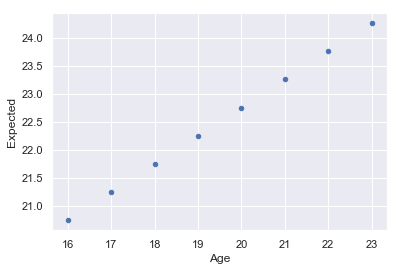

In [11]:
age = range(16, 24)
expected = clf.predict(np.array(age).reshape(-1, 1))

pd.DataFrame(list(zip(age, expected)), columns=['Age', 'Expected']).plot.scatter('Age', 'Expected')

## Labeling successes and busts

In [12]:
def apply_label(x):
    dt = pd.to_datetime(x['birthdate'])
    if x is None or dt is None or ((x['expected'] + dt.year > 2020) and pd.isnull(x['debut_age'])):
        return -1
    elif x['expected'] > x['debut_age']:
        return 1
    return 0

In [13]:
print(f"Before (blank etas): {(df.eta == '').sum()}")
df.eta.replace('', np.nan, inplace=True)
print(f"After (blank etas): {df.eta.dtype}") # (df.eta == '').sum()

print(f'Before: {df.eta.count()}')

expected = pd.to_numeric(df.age, errors='coerce').apply(estimate_eta)
filled_etas = (expected + pd.to_datetime(df.birthdate).dt.year).fillna(-1).astype(int)
df.fillna({'eta': filled_etas}, inplace=True)

print(f'After: {df.eta.count()}')

df.eta.value_counts()

Before (blank etas): 1704
After (blank etas): float64
Before: 10583
After: 13616


-1.0       3013
 2019.0    1972
 2020.0    1697
 2021.0    1425
 2018.0    1396
 2022.0    1028
 2017.0     976
 2016.0     632
 2023.0     552
 2015.0     401
 2014.0     256
 2024.0     159
 2013.0      74
 2025.0      31
 2012.0       2
 2011.0       2
Name: eta, dtype: int64

In [14]:
df[((df.eta <= 2020) | ~df.debut_age.isnull()) & (df.eta != -1)].key_fangraphs.count()

5260

In [15]:
df[df.eta.replace('', 3000).fillna(3000).astype(int) < 2020].shape

(8724, 90)

In [16]:
mask = ~df.age.isnull()

df.loc[:, 'expected'] = -1
df.loc[mask, 'expected'] = clf.predict(df.loc[mask, 'age'].replace('', 0).fillna(0).values.reshape(-1, 1)).round(3)

df = df[df.eta.replace(-1, 3000).fillna(3000).astype(int) < 2020]
df['label'] = (df.fillna({'debut_age': 0}).debut_age.astype(int) <= df['expected']).astype(int)
df.loc[df.debut_age.isnull(), 'label'] = 0
                                                                                                  
df.loc[df.key_fangraphs.isin(['', 0, None]), 'key_fangraphs'] = np.nan
df.loc[df.report.isin(['', 0, np.nan, None]), 'report'] = ''

#df.to_json('labelled_data.json', orient='split')
print(df.shape)
df.head()

(5711, 92)


,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,Cent%_h,Oppo%_h,SwStr%_h,Balls_h,Strikes_h,Pitches_h,PlayerId_h,Level_h,expected,label
0,Luis Perdomo,21.6482,2015,RHP,2018.0,Not to be confused with the Luis Perdomo the C...,0,50,50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.577,1
1,Bruce Maxwell,24,2015,C,2016.0,Maxwell led NCAA Division III with 15 homers ...,55,0,0,0,...,0.2091,0.3415,0.0593,556.0,877.0,1433.0,13866,AA,24.752,0
3,Anthony Banda,22.4,2016,LHP,2017.0,"In 2011, the D-backs drafted Banda in the 33rd...",0,45,50,55,...,0.4000,0.6000,0.3455,16.0,39.0,55.0,14706,AAA,23.953,1
4,Mike Wright,23,2013,RHP,2014.0,The East Carolina product jumped on the fast t...,0,50,50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.253,0
5,Deivi Grullon,18.872,2015,C,2018.0,Grullon was the Phillies' top prize in the 20...,70,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.189,0


In [17]:
df.loc[df.label == 0, ['name', 'year', 'eta', 'age', 'birthdate','expected','debut_age','label']]

,name,year,eta,age,birthdate,expected,debut_age,label
1,Bruce Maxwell,2015,2016.0,24,1990-12-20T00:00:00.000Z,24.752,25.0,0
4,Mike Wright,2013,2014.0,23,1990-01-03T00:00:00.000Z,24.253,25.0,0
5,Deivi Grullon,2015,2018.0,18.872,1996-02-17T00:00:00.000Z,22.189,NaN,0
7,Brendan Rodgers,2015,2019.0,18.4,1996-08-09T00:00:00.000Z,21.954,22.4,0
12,Brett Martin,2015,2018.0,19.7,1995-04-28T00:00:00.000Z,22.603,23.7,0
13,Daz Cameron,2017,2019.0,20,1997-01-15T00:00:00.000Z,22.753,NaN,0
23,Cornelius Randolph,2015,2019.0,17.6,1997-06-02T00:00:00.000Z,21.554,NaN,0
28,Nick Travieso,2016,2017.0,21.9,1994-01-31T00:00:00.000Z,23.703,NaN,0
30,Trey Michalczewski,2014,2017.0,18.8,1995-02-27T00:00:00.000Z,22.153,NaN,0
31,Jarlin Garcia,2015,2016.0,21.9521,1993-01-18T00:00:00.000Z,23.729,24.0,0


In [18]:
df['label'].value_counts()

0    3849
1    1862
Name: label, dtype: int64

In [19]:
df.drop(columns=dropped_cols).to_csv('labels.csv', index=False)

In [25]:
(~(df.key_bbref.isnull() & df.key_bbref_minors.isnull())).count()

5711

In [26]:
df.key_mlbam.count()

3975

In [54]:
df.report.replace('', np.nan).count()

4594

In [39]:
mask = ~df.age.isnull()

df['expected'] = -1
df.loc[mask, 'expected'] = clf.predict(df.loc[mask, 'age'].replace('', 0).fillna(0).values.reshape(-1, 1)).round(3)

mask = ~df.age.isnull()

too_young = ((df.expected + pd.to_datetime(df.birthdate).dt.year) > 2020) | (df.expected == -1)
success = (df['debut_age'].fillna(0) <= df['expected']) 

df.loc[df.debut_age == -1, 'label'] = 0
df.loc[too_young, 'label'] = -1 # label[mask]
df.loc[df.label != -1, 'label'] = success.astype(int)



df.head()

,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,Cent%_h,Oppo%_h,SwStr%_h,Balls_h,Strikes_h,Pitches_h,PlayerId_h,Level_h,expected,label
0,Luis Perdomo,21.6482,2015,RHP,2018.0,Not to be confused with the Luis Perdomo the C...,0,50,50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.577,1
1,Bruce Maxwell,24,2015,C,2016.0,Maxwell led NCAA Division III with 15 homers ...,55,0,0,0,...,0.2091,0.3415,0.0593,556.0,877.0,1433.0,13866,AA,24.752,0
3,Anthony Banda,22.4,2016,LHP,2017.0,"In 2011, the D-backs drafted Banda in the 33rd...",0,45,50,55,...,0.4000,0.6000,0.3455,16.0,39.0,55.0,14706,AAA,23.953,1
4,Mike Wright,23,2013,RHP,2014.0,The East Carolina product jumped on the fast t...,0,50,50,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.253,0
5,Deivi Grullon,18.872,2015,C,2018.0,Grullon was the Phillies' top prize in the 20...,70,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.189,1


In [30]:
df.label.value_counts() / len(df)

AttributeError: 'DataFrame' object has no attribute 'label'

In [18]:
df.label.count()

11892

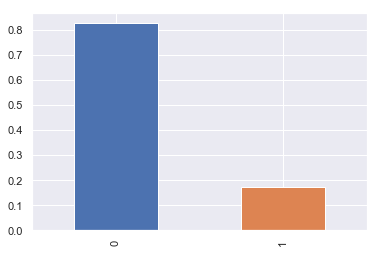

In [9]:
(df.label.value_counts() / len(df)).plot.bar()

In [10]:
df[(df.label == 0) & (df.eta.replace('', 0).astype(int, errors='ignore') >= 2019)]

,name,age,year,primary_position,eta,report,Arm,Changeup,Control,Curveball,...,uid,key_uuid,key_bbref,key_bbref_minors,mlb_played_first,birthdate,debut_age,key_fangraphs,expected,label
2,Sam Huff,20,2018,C,2021,Huff led Arizona high schoolers with 14 homers...,50,0,0,0,...,0_2018,cf05afc8-7884-4dd6-b1d5-fbca7ddce9bc,None,huff--000sam,NaN,1998-01-14T00:00:00.000Z,NaN,None,-1.00,0
6,Jefrey Ramos,None,2019,OF,2022,The Braves went all-in during the 2016-17 inte...,40,0,0,0,...,0_2019,4c2df4cb-8629-40b3-9623-55515be07028,None,ramos-002jef,NaN,1999-02-10T00:00:00.000Z,NaN,None,-1.00,0
9,Travis Blankenhorn,22.4,2019,2B,2020,Blankenhorn was an outstanding athlete in high...,50,0,0,0,...,0_2019,d7a1e5d6-392d-4697-99b6-bd135028ac7f,None,blanke002tra,NaN,1996-08-03T00:00:00.000Z,NaN,None,-1.00,0
13,Daz Cameron,20,2017,OF,2019,"As a high school sophomore, Cameron emerged as...",50,0,0,0,...,0_2017,de4d33e2-7d08-4909-a8e4-172308a6cd51,None,camero000daz,NaN,1997-01-15T00:00:00.000Z,NaN,None,-1.00,0
15,Grant Little,20.5,2018,OF,2021,Left-hander Steven Gingery and right-hander Da...,45,0,0,0,...,0_2018,1bb71897-8f04-459f-aeac-84e2c304dffd,None,little000gra,NaN,1997-07-08T00:00:00.000Z,NaN,None,-1.00,0
20,Oscar Tovar,None,2017,RHP,2020,An international signee in 2014 out of Venezue...,0,45,45,0,...,0_2017,781e1b5e-9d3b-45f9-abc5-f3cd52d0832f,None,tovar-000osc,NaN,1998-03-19T00:00:00.000Z,NaN,None,-1.00,0
22,Jose Sanchez,None,2017,SS,2021,The Nationals blew well past their allotted bo...,50,0,0,0,...,0_2017,06316ece-a828-4152-bfdb-0f23c2aa354b,None,sanche034jos,NaN,2000-07-12T00:00:00.000Z,NaN,None,-1.00,0
23,Cornelius Randolph,17.6,2015,OF,2019,Griffin (Ga.) High School in Georgia last had...,55,0,0,0,...,0_2015,a3016614-b484-4b98-ab3d-5634e8b4f0cc,None,randol000cor,NaN,1997-06-02T00:00:00.000Z,NaN,None,-1.00,0
26,Mason Englert,18.2,2018,RHP,2022,Though he wasn't considered the best pitching ...,0,50,50,50,...,0_2018,baf49334-5b60-4b07-b6f9-a56a073bb649,None,engler000mas,NaN,1999-11-01T00:00:00.000Z,NaN,None,-1.00,0
32,Gage Hinsz,18.7,2015,RHP,2019,High school pitchers from places like Montana ...,0,45,45,45,...,0_2015,0307a5d7-f9a3-43f1-8967-77e6ec8278ba,None,hinsz-000gag,NaN,1996-04-20T00:00:00.000Z,NaN,None,-1.00,0
